In [1]:
from functools import partial

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np

Now we try and build the mfe single tube model.

In [2]:
import pysac.mhs_atmosphere as atm
from pysac.mhs_atmosphere.parameters.model_pars import mfe_setup as model_pars

In [3]:
# Cheeky Reset to Photosphere
model_pars['xyz'][4] = 0*u.Mm

In [4]:
# model setup
scales, physical_constants = atm.units_const.get_parameters()
option_pars = atm.options.set_options(model_pars, False, l_gdf=True)
coords = atm.model_pars.get_coords(model_pars['Nxyz'], u.Quantity(model_pars['xyz']))

#interpolate the hs 1D profiles from empirical data source[s]
empirical_data = atm.hs_atmosphere.read_VAL3c_MTW(mu=physical_constants['mu'])
table = atm.hs_atmosphere.interpolate_atmosphere(empirical_data, coords['Zext'])

In [5]:
#==============================================================================
#calculate 1d hydrostatic balance from empirical density profile
#==============================================================================
# the hs pressure balance is enhanced by pressure equivalent to the
# residual mean coronal magnetic pressure contribution once the magnetic
# field has been applied
magp_meanz = np.ones(len(coords['Z'])) * u.one
magp_meanz *= model_pars['pBplus']**2/(2*physical_constants['mu0'])

pressure_z, rho_z, Rgas_z = atm.hs_atmosphere.vertical_profile(coords['Z'], table, magp_meanz,
                                                               physical_constants, coords['dz'])

In [6]:
x, y, z = u.Quantity(np.mgrid[coords['xmin']:coords['xmax']:1j*model_pars['Nxyz'][0],
                              coords['ymin']:coords['ymax']:1j*model_pars['Nxyz'][1],
                              coords['zmin']:coords['zmax']:1j*model_pars['Nxyz'][2]], unit=coords['xmin'].unit)

In [7]:
xi, yi, Si = atm.flux_tubes.get_flux_tubes(model_pars, coords, option_pars)

In [8]:
allmag = atm.flux_tubes.construct_magnetic_field(x, y, z,
                                                 xi[0], yi[0], Si[0],
                                                 model_pars, option_pars,
                                                 physical_constants,
                                                 scales)
pressure_m, rho_m, Bx, By ,Bz, Btensx, Btensy = allmag

('pbbal.max() = ', <Quantity 0.018463625145904203 kg / (m s2)>)


In [9]:
# local proc 3D mhs arrays
pressure, rho = atm.mhs_3D.mhs_3D_profile(z,
                                          pressure_z,
                                          rho_z,
                                          pressure_m,
                                          rho_m)
magp = (Bx**2 + By**2 + Bz**2) / (2.*physical_constants['mu0'])
energy = atm.mhs_3D.get_internal_energy(pressure, magp, physical_constants)

In [10]:
x_lin = np.linspace(coords['xmin'], coords['xmax'], model_pars['Nxyz'][0])

In [11]:
bmag = np.sqrt((Bx**2 + By**2 + Bz**2))[:,64,0].to(u.mT)

In [12]:
atm.flux_tubes.get_flux_tubes(model_pars, coords, option_pars)

(<Quantity [[ 0.]] Mm>, <Quantity [[ 0.]] Mm>, <Quantity [[ 0.13]] T>)

In [13]:
coords['zmin']

<Quantity 0.0 Mm>

In [14]:
from astropy.modeling import models, fitting

In [15]:
gaussian = models.Gaussian1D()
bmag_fit = fitting.LevMarLSQFitter()(gaussian, x_lin, bmag)

In [16]:
fwhm = 2.*np.sqrt(2*np.log(2))*bmag_fit.stddev.value
fwhm = np.abs(fwhm) * u.Mm
fwhm

<Quantity 0.1047501976061136 Mm>

In [17]:
bmag_fit

<Gaussian1D(amplitude=128.27588597053662, mean=1.894433324264e-18, stddev=-0.04448331320567507)>

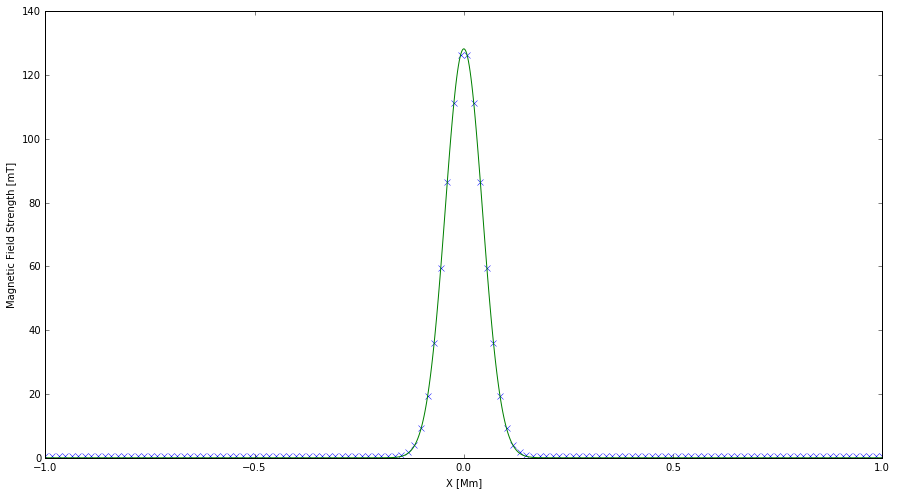

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, bmag.to(u.mT), 'x')
X = np.linspace(coords['xmin'], coords['xmax'], 1000)
plt.plot(X, bmag_fit(X.value))

plt.xlabel("X [{}]".format(x.unit))
plt.ylabel("Magnetic Field Strength [{}]".format(bmag.unit))
fig

## Now for some plotting

In [19]:
import yt

In [20]:
def magnetic_field_strength(field, data):
        return np.sqrt(data["magnetic_field_x"]**2 + data["magnetic_field_y"]**2 + data["magnetic_field_z"]**2)
yt.add_field(("gas","magnetic_field_strength"),
             function=magnetic_field_strength,
             units = "T")

In [21]:
def plasma_beta(field, data):
        return data['pressure'] / data['magnetic_pressure']
yt.add_field(("gas","plasma_beta"),
             function=plasma_beta,
             units = "")

In [22]:
def alfven_speed(field, data):
    return np.sqrt(2.*data['magnetic_pressure']/data['density'])
yt.add_field(("gas","alfven_speed"),
             function=alfven_speed,
             units = "m/s")

In [23]:
def sound_speed(field, data):
    cspeed = np.sqrt(physical_constants['gamma']*pressure/rho)
    return cspeed
yt.add_field(("gas","sound_speed"),
             function=sound_speed,
             units = "m/s", force_override=True)

In [24]:
bbox = u.Quantity([u.Quantity([coords['xmin'], coords['xmax']]),
                   u.Quantity([coords['ymin'], coords['ymax']]),
                   u.Quantity([coords['zmin'], coords['zmax']])]).to(u.m).value

In [25]:
data = {'magnetic_field_x':yt.YTQuantity.from_astropy(Bx.decompose()),
        'magnetic_field_y':yt.YTQuantity.from_astropy(By.decompose()),
        'magnetic_field_z':yt.YTQuantity.from_astropy(Bz.decompose()),
        'pressure': yt.YTQuantity.from_astropy(pressure.decompose()),
        'magnetic_pressure': yt.YTQuantity.from_astropy(magp.decompose()),
        'density': yt.YTQuantity.from_astropy(rho.decompose())}

In [26]:
ds = yt.load_uniform_grid(data, x.shape,
                          length_unit='m', magnetic_unit='T', mass_unit='kg',
                          periodicity=[False]*3, bbox=bbox)

yt : [INFO     ] 2015-07-16 17:25:08,970 Parameters: current_time              = 0.0
yt : [INFO     ] 2015-07-16 17:25:08,971 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2015-07-16 17:25:08,973 Parameters: domain_left_edge          = [-1000000. -1000000.        0.]
yt : [INFO     ] 2015-07-16 17:25:08,975 Parameters: domain_right_edge         = [ 1000000.  1000000.  1600000.]
yt : [INFO     ] 2015-07-16 17:25:08,977 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2015-07-16 17:25:09,132 Loading field plugins.
yt : [INFO     ] 2015-07-16 17:25:09,133 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,134 Loaded astro (15 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,136 Loaded cosmology (22 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,138 Loaded fluid (63 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,140 Loaded fluid_vector (95 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,142 Loaded geometric (111 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,143 Loaded local (115 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,144 Loaded magnetic_field (119 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,145 Loaded my_plugins (119 new fields)
yt : [INFO     ] 2015-07-16 17:25:09,146 Loaded species (121 new fields)
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from IPython.kernel.zmq import kernelapp as app
yt : [INFO     ] 2015-07-16


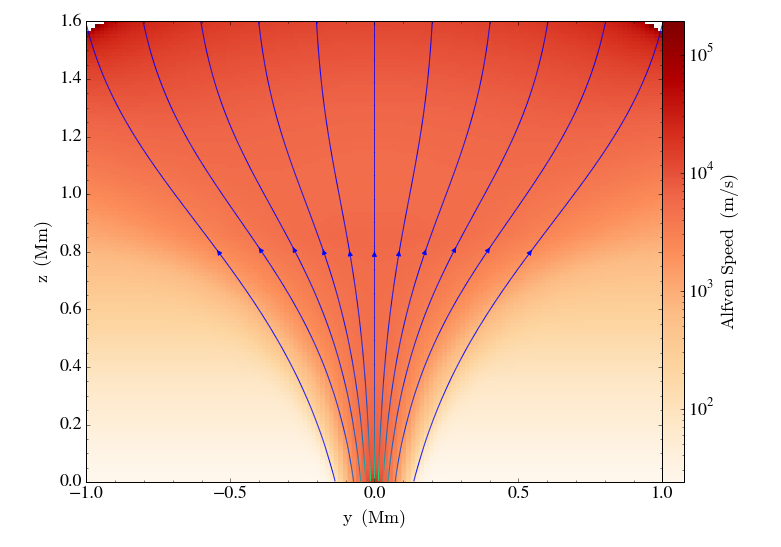

In [27]:
slc = yt.SlicePlot(ds, 'x', 'alfven_speed', origin='lower-center-domain', axes_unit='Mm')
slc.set_cmap('all', 'OrRd')

seed_points = np.zeros([11,2]) + 1.52
seed_points[:,0] = np.linspace(-0.99, 0.95, seed_points.shape[0], endpoint=True)
slc.annotate_streamlines('magnetic_field_y', 'magnetic_field_z', field_color='magnetic_field_strength',
                         plot_args={'start_points':seed_points, 'density':15, 'cmap':'winter'})

yt : [INFO     ] 2015-07-16 17:25:13,067 xlim = -1000000.000000 1000000.000000
yt : [INFO     ] 2015-07-16 17:25:13,068 ylim = 0.000000 1600000.000000
yt : [INFO     ] 2015-07-16 17:25:13,073 xlim = -1000000.000000 1000000.000000
yt : [INFO     ] 2015-07-16 17:25:13,074 ylim = 0.000000 1600000.000000
yt : [INFO     ] 2015-07-16 17:25:13,087 Making a fixed resolution buffer of (('gas', 'magnetic_field_strength')) 800 by 800



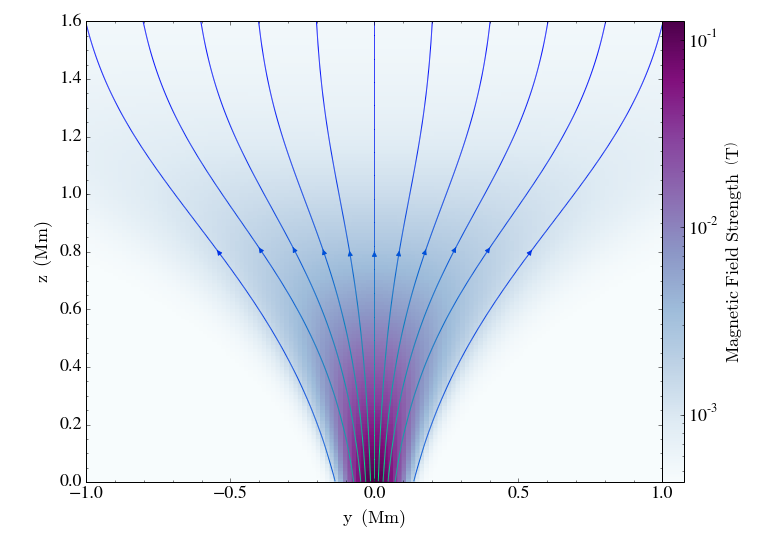

In [28]:
slc = yt.SlicePlot(ds, 'x', 'magnetic_field_strength', origin='lower-center-domain',
                   axes_unit='Mm')
slc.set_cmap('all', 'BuPu')
#slc.annotate_contour('plasma_beta')

seed_points = np.zeros([11,2]) + 1.52
seed_points[:,0] = np.linspace(-0.99, 0.95, seed_points.shape[0], endpoint=True)
slc.annotate_streamlines('magnetic_field_y', 'magnetic_field_z', field_color='magnetic_field_strength',
                         plot_args={'start_points':seed_points, 'density':15, 'cmap':'winter',
                                    'norm': slc.plots['magnetic_field_strength'].image.norm})